In [1]:
import pandas as pd
import pickle
import glob
import os
from psimapacthelper import *
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go

# Generating the required metrics

In [2]:
### Read the data

# Specify the folder path containing pickle files
folder_path = 'Calibration/final_data/'

# Define the pattern to match for pickle files
file_pattern = 'datalist_seed*.pkl'

# Find all matching files
file_paths = glob.glob(os.path.join(folder_path, file_pattern))

# Initialize an empty dictionary to store loaded data
loaded_data = {}

# Load each pickle file
for file_path in file_paths:
    with open(file_path, 'rb') as f:
        # Extract the seed number from the file name
        seed_number = int(file_path.split('seed')[1].split('.')[0])
        # Load the pickle file and store in the dictionary
        loaded_data[f'model{seed_number}'] = pickle.load(f)

In [3]:
sim_size = 2000
scaling_factor = 598564/sim_size

In [4]:
agegroup = [15, 50]
evaluation_timepoints = np.arange(0.5, 66.0, 1.0) # !!!! remember to change to 66 in the next round

In [5]:
evaluation_timepoints_inc = np.arange(0, 66.0, 1.0) 

In [6]:
# Define mapping from gender and timepoint to years,
gender = {
    0: 'Male',
    1: 'Female',
    'Total':'Total'}

timepoint_to_year = {timepoint: year for timepoint, year in enumerate(range(1980, 2051))}

In [7]:
excel_file = f'Calibration/final_output_calib_version_{datetime.now().strftime("%Y-%m-%d_%H:%M:%S")}.xlsx'
excel_file

'Calibration/final_output_calib_version_2024-08-02_10:21:08.xlsx'

### Population Size age 15-49 mid-year

In [8]:
# Initialize an empty list to store individual dataframes
dfs = []

for seed_number, datalist in loaded_data.items():
    for timepoint in evaluation_timepoints:
        # agegroup = [15, 50]
        result_df = population_calculator(datalist=datalist, agegroup=agegroup,timepoint=timepoint)
        result_df['timepoint'] = timepoint - 0.5
        result_df['model'] = seed_number

        # Append the resulting dataframe to the list
        dfs.append(result_df)

# Concatenate all dataframes in the list into a single dataframe
pop_combined_df = pd.concat(dfs, ignore_index=True)

# Replace timepoint with years, gender with actual gender string
pop_combined_df['Year'] = pop_combined_df['timepoint'].map(timepoint_to_year)
pop_combined_df['Gender'] = pop_combined_df['Gender'].map(gender)

In [9]:
population_df = pop_combined_df.groupby(['Gender','Year']).agg(
            Population=('popsize', 'mean')  # Average pop for each gender
        ).reset_index()

population_df['Actual_Population'] = round(population_df['Population']*scaling_factor)

In [10]:
population_wide_df = population_df.pivot(index='Year', columns='Gender', values='Actual_Population').reset_index()
population_wide_df.columns.name = None  # Remove the name of the columns index

with pd.ExcelWriter(excel_file, engine='xlsxwriter') as writer:
    # Write each dataframe to a different worksheet
    population_wide_df.to_excel(writer, sheet_name='Population Size', index=False)

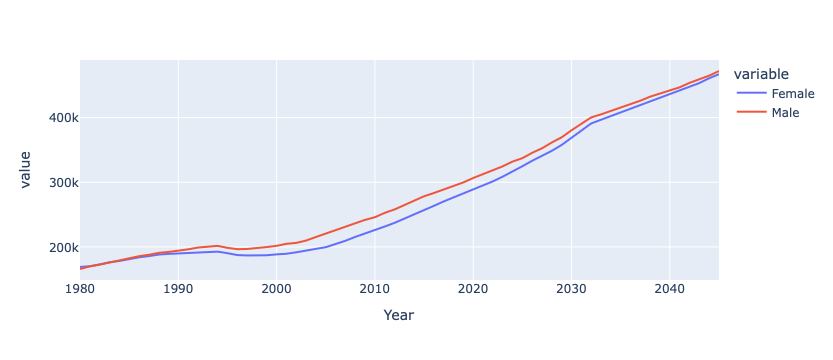

In [11]:
px.line(data_frame=population_wide_df, x='Year', y=['Female','Male'])

### HIV prevalence age 15-49 population

In [12]:
# Initialize an empty list to store individual dataframes
dfs = []

for seed_number, datalist in loaded_data.items():
    for timepoint in evaluation_timepoints:
        # agegroup = [15, 50]
        result_df = prevalence_calculator(datalist=datalist, agegroup=agegroup,timepoint=timepoint)
        result_df['timepoint'] = timepoint - 0.5
        result_df['model'] = seed_number

        # Append the resulting dataframe to the list
        dfs.append(result_df)

# Concatenate all dataframes in the list into a single dataframe
prev_combined_df = pd.concat(dfs, ignore_index=True)

# Replace timepoint with years, gender with actual gender string
prev_combined_df['Year'] = prev_combined_df['timepoint'].map(timepoint_to_year)
prev_combined_df['Gender'] = prev_combined_df['Gender'].map(gender)

In [13]:
prevalence_df = prev_combined_df.groupby(['Gender','Year']).agg(
            pointprevalence=('pointprevalence', 'mean')  # Average pop for each gender
        ).reset_index()

In [14]:
prevalence_wide_df = prevalence_df.pivot(index='Year', columns='Gender', values='pointprevalence').reset_index()
prevalence_wide_df.columns.name = None  # Remove the name of the columns index

with pd.ExcelWriter(excel_file, engine='xlsxwriter') as writer:
    # Write each dataframe to a different worksheet
    population_wide_df.to_excel(writer, sheet_name='Population Size', index=False)
    prevalence_wide_df.to_excel(writer, sheet_name='HIV Prevalence', index=False)

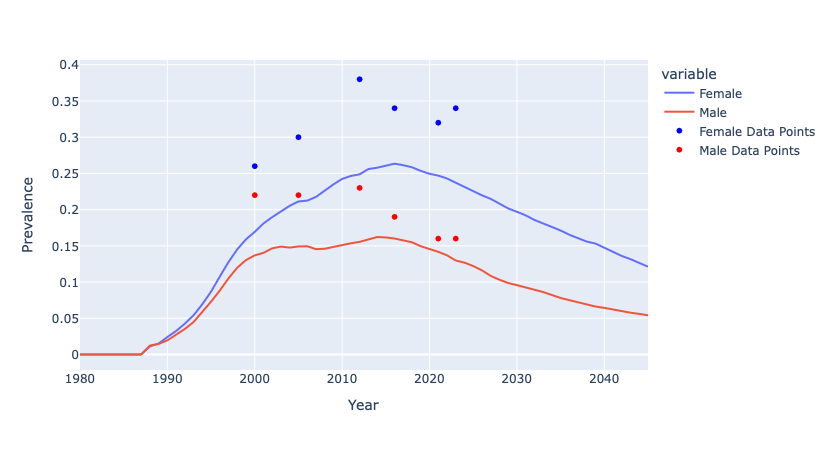

In [15]:
fig = px.line(data_frame=prevalence_wide_df, x='Year', y=['Female','Male'], width=890, height=450)
fig.update_layout(
    xaxis_title="Year", yaxis_title="Prevalence"
)

# Data points to add
points = [
    {'Year': 2000, 'Female': .26, 'Male': .22},
    {'Year': 2005, 'Female': .30, 'Male': .22},
    {'Year': 2012, 'Female': .38, 'Male': .23},
    {'Year': 2016, 'Female': .34, 'Male': .19},
    {'Year': 2021, 'Female': .32, 'Male': .16},
    {'Year': 2023, 'Female': .34, 'Male': .16},
    # Add more points as needed
]

# Add points for Female
fig.add_trace(
    go.Scatter(
        x=[point['Year'] for point in points],
        y=[point['Female'] for point in points],
        mode='markers',
        name='Female Data Points',
        marker=dict(color='blue', size=6)
    )
)

# Add points for Male
fig.add_trace(
    go.Scatter(
        x=[point['Year'] for point in points],
        y=[point['Male'] for point in points],
        mode='markers',
        name='Male Data Points',
        marker=dict(color='red', size=6)
    )
)

# Show the plot
fig.show()

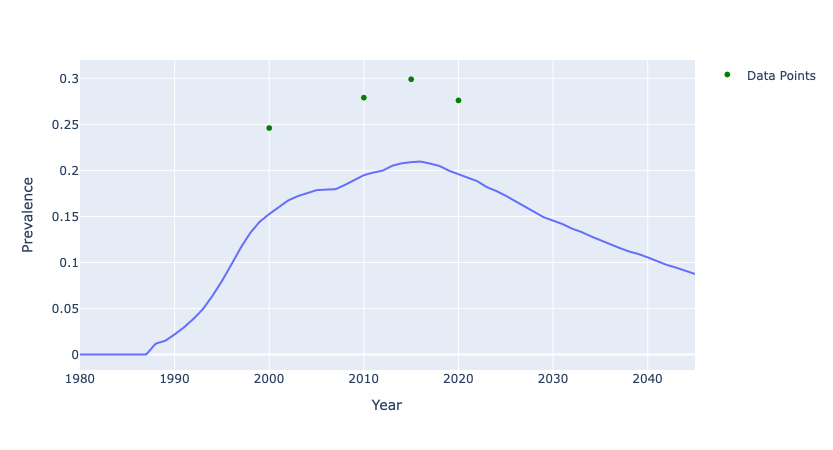

In [16]:
fig = px.line(data_frame=prevalence_wide_df, x='Year', y='Total', width=890, height=450)
fig.update_layout(
    xaxis_title="Year", yaxis_title="Prevalence"
)

# Data points to add
points = [
    {'Year': 2000, 'Total': .246},
    {'Year': 2010, 'Total': .279},
    {'Year': 2015, 'Total': .299},
    {'Year': 2020, 'Total': .276},
    # Add more points as needed
]

# Add points for Female
fig.add_trace(
    go.Scatter(
        x=[point['Year'] for point in points],
        y=[point['Total'] for point in points],
        mode='markers',
        name='Data Points',
        marker=dict(color='green', size=6)
    )
)

# Show the plot
fig.show()

### HIV incidence as new infections per 1000 uninfected population  (15-49)

In [17]:
# Initialize an empty list to store individual dataframes
dfs = []

for seed_number, datalist in loaded_data.items():
    for timepoint in evaluation_timepoints_inc:
        timewindow = [timepoint, timepoint+1]
        result_df = incidence_calculator(datalist=datalist, agegroup=agegroup,timewindow=timewindow)
        result_df['timepoint'] = timepoint+1
        result_df['model'] = seed_number

        # Append the resulting dataframe to the list
        dfs.append(result_df)

# Concatenate all dataframes in the list into a single dataframe
inc_combined_df = pd.concat(dfs, ignore_index=True)

# Replace timepoint with years, gender with actual gender string
inc_combined_df['Year'] = inc_combined_df['timepoint'].map(timepoint_to_year)
inc_combined_df['Gender'] = inc_combined_df['Gender'].map(gender)

In [18]:
incidence_df = inc_combined_df.groupby(['Gender','Year']).agg(
            incidence=('incidence', 'mean')  # Average pop for each gender
        ).reset_index()

incidence_df['incidence'] = round(incidence_df['incidence'] * 1000, 3)

In [19]:
incidence_wide_df = incidence_df.pivot(index='Year', columns='Gender', values='incidence').reset_index()
incidence_wide_df.columns.name = None  # Remove the name of the columns index

with pd.ExcelWriter(excel_file, engine='xlsxwriter') as writer:
    # Write each dataframe to a different worksheet
    population_wide_df.to_excel(writer, sheet_name='Population Size', index=False)
    prevalence_wide_df.to_excel(writer, sheet_name='HIV Prevalence', index=False)
    incidence_wide_df.to_excel(writer, sheet_name='HIV incidence per 1000', index=False)

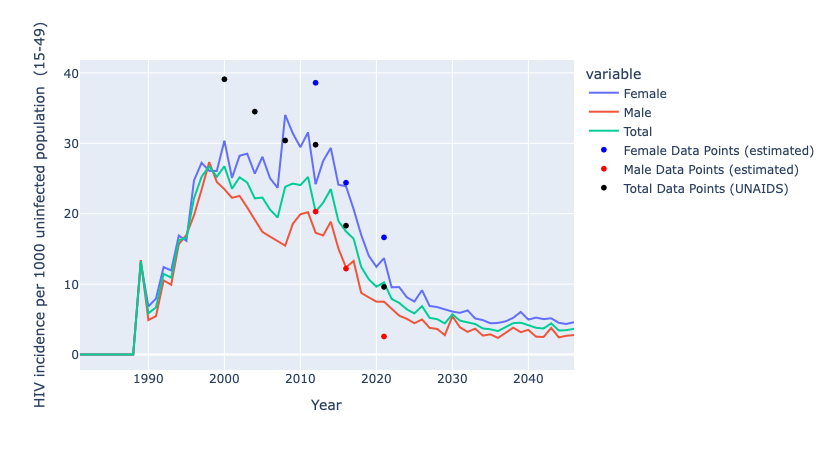

In [20]:
fig = px.line(data_frame=incidence_wide_df, x='Year', y=['Female','Male','Total'],width=890, height=450)
fig.update_layout(
    xaxis_title="Year", yaxis_title="HIV incidence per 1000 uninfected population  (15-49)"
)

# Data points to add
points = [
    {'Year': 2000, 'Female': np.nan, 'Male': np.nan,'Total': 39.1},
    {'Year': 2004, 'Female': np.nan, 'Male': np.nan, 'Total': 34.5},
    {'Year': 2008, 'Female': np.nan, 'Male': np.nan, 'Total': 30.4},
    # {'Year': 2012, 'Female': 31.4, 'Male': 16.5, 'Total': 29.8}, #shims
    # {'Year': 2016, 'Female': 19.9, 'Male': 9.9, 'Total': 18.3}, #shims
    # {'Year': 2021, 'Female': 14.5, 'Male': 2,'Total': 9.6} #shims
    {'Year': 2012, 'Female': 38.6, 'Male': 20.3, 'Total': 29.8},
    {'Year': 2016, 'Female': 24.4, 'Male': 12.2, 'Total': 18.3},
    {'Year': 2021, 'Female': 16.64, 'Male': 2.56,'Total': 9.6}
    # Add more points as needed
]

# Add points for Female
fig.add_trace(
    go.Scatter(
        x=[point['Year'] for point in points],
        y=[point['Female'] for point in points],
        mode='markers',
        name='Female Data Points (estimated)',
        marker=dict(color='blue', size=6)
    )
)

# Add points for Male
fig.add_trace(
    go.Scatter(
        x=[point['Year'] for point in points],
        y=[point['Male'] for point in points],
        mode='markers',
        name='Male Data Points (estimated)',
        marker=dict(color='red', size=6)
    )
)

# Add points for Total
fig.add_trace(
    go.Scatter(
        x=[point['Year'] for point in points],
        y=[point['Total'] for point in points],
        mode='markers',
        name='Total Data Points (UNAIDS)',
        marker=dict(color='black', size=6)
    )
)

# Show the plot
fig.show()

### Of those diagnosed, % on ART age 15-49

In [21]:
# Initialize an empty list to store individual dataframes
dfs = []

for seed_number, datalist in loaded_data.items():
    for timepoint in evaluation_timepoints:
        # agegroup = [15, 50]
        result_df = ART_coverage_calculator(datalist=datalist, agegroup=agegroup,timepoint=timepoint)
        result_df['timepoint'] = timepoint - 0.5
        result_df['model'] = seed_number

        # Append the resulting dataframe to the list
        dfs.append(result_df)

# Concatenate all dataframes in the list into a single dataframe
ART_combined_df = pd.concat(dfs, ignore_index=True)

# Replace timepoint with years, gender with actual gender string
ART_combined_df['Year'] = ART_combined_df['timepoint'].map(timepoint_to_year)
ART_combined_df['Gender'] = ART_combined_df['Gender'].map(gender)

In [22]:
ART_df = ART_combined_df.groupby(['Gender','Year']).agg(
            ART_coverage=('ART_coverage', 'mean')  # Average pop for each gender
        ).reset_index()

In [23]:
ART_wide_df = ART_df.pivot(index='Year', columns='Gender', values='ART_coverage').reset_index()
ART_wide_df.columns.name = None  # Remove the name of the columns index

with pd.ExcelWriter(excel_file, engine='xlsxwriter') as writer:
    # Write each dataframe to a different worksheet
    population_wide_df.to_excel(writer, sheet_name='Population Size', index=False)
    prevalence_wide_df.to_excel(writer, sheet_name='HIV Prevalence', index=False)
    incidence_wide_df.to_excel(writer, sheet_name='HIV Incidence per 1000', index=False)
    ART_wide_df.to_excel(writer, sheet_name='ART Coverage', index=False)

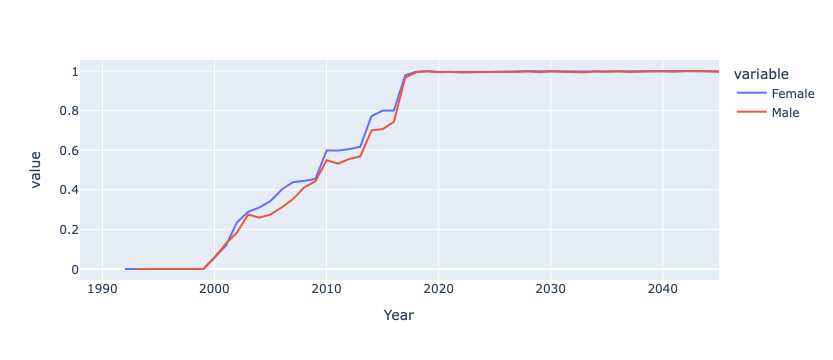

In [24]:
px.line(data_frame=ART_wide_df, x='Year', y=['Female','Male'])

### New HIV infections age 15-49 pop

In [25]:
new_infections_df = inc_combined_df.groupby(['Gender','Year']).agg(
            sum_incident_cases=('sum_incident_cases', 'mean')  # Average pop for each gender
        ).reset_index()

new_infections_df['sum_incident_cases_actual'] = round(new_infections_df['sum_incident_cases']*scaling_factor)

In [26]:
new_infections_wide_df = new_infections_df.pivot(index='Year', columns='Gender', values='sum_incident_cases_actual').reset_index()
new_infections_wide_df.columns.name = None  # Remove the name of the columns index

with pd.ExcelWriter(excel_file, engine='xlsxwriter') as writer:
    # Write each dataframe to a different worksheet
    population_wide_df.to_excel(writer, sheet_name='Population Size', index=False)
    prevalence_wide_df.to_excel(writer, sheet_name='HIV Prevalence', index=False)
    incidence_wide_df.to_excel(writer, sheet_name='HIV Incidence per 1000', index=False)
    ART_wide_df.to_excel(writer, sheet_name='ART Coverage', index=False)
    new_infections_wide_df.to_excel(writer, sheet_name='New HIV infections', index=False)

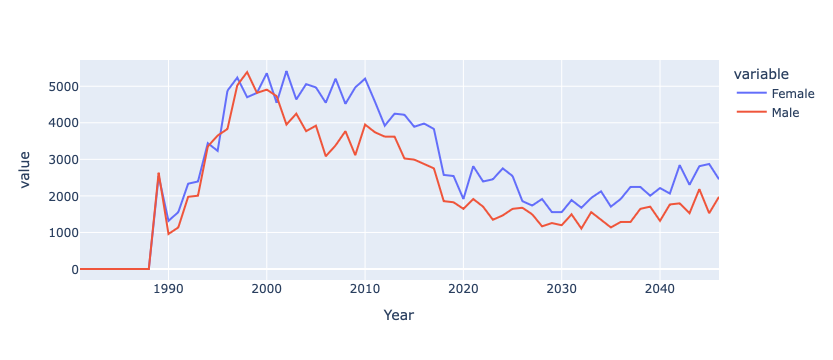

In [27]:
px.line(data_frame=new_infections_wide_df, x='Year', y=['Female','Male'])

### Number of people on treatment (all ages)

In [28]:
# Initialize an empty list to store individual dataframes
dfs = []

for seed_number, datalist in loaded_data.items():
    for timepoint in evaluation_timepoints:
        # agegroup = [0, 300]
        result_df = ART_coverage_calculator(datalist=datalist, agegroup=agegroup,timepoint=timepoint)
        result_df['timepoint'] = timepoint - 0.5
        result_df['model'] = seed_number

        # Append the resulting dataframe to the list
        dfs.append(result_df)

# Concatenate all dataframes in the list into a single dataframe
ART_numbers_df = pd.concat(dfs, ignore_index=True)

# Replace timepoint with years, gender with actual gender string
ART_numbers_df['Year'] = ART_numbers_df['timepoint'].map(timepoint_to_year)
ART_numbers_df['Gender'] = ART_numbers_df['Gender'].map(gender)

In [29]:
ART_numbers_combined_df = ART_numbers_df.groupby(['Gender','Year']).agg(
            ART_numbers_all=('sum_onART', 'mean')  # Average pop for each gender
        ).reset_index()

ART_numbers_combined_df['ART_numbers_all_actual'] = ART_numbers_combined_df['ART_numbers_all']*scaling_factor

In [30]:
ART_numbers_combined_wide_df = ART_numbers_combined_df.pivot(index='Year', columns='Gender', values='ART_numbers_all_actual').reset_index()
ART_numbers_combined_wide_df.columns.name = None  # Remove the name of the columns index

with pd.ExcelWriter(excel_file, engine='xlsxwriter') as writer:
    # Write each dataframe to a different worksheet
    population_wide_df.to_excel(writer, sheet_name='Population Size', index=False)
    prevalence_wide_df.to_excel(writer, sheet_name='HIV Prevalence', index=False)
    incidence_wide_df.to_excel(writer, sheet_name='HIV Incidence per 1000', index=False)
    ART_wide_df.to_excel(writer, sheet_name='ART Coverage', index=False)
    ART_numbers_combined_wide_df.to_excel(writer, sheet_name='On Treatemnt All Ages', index=False)

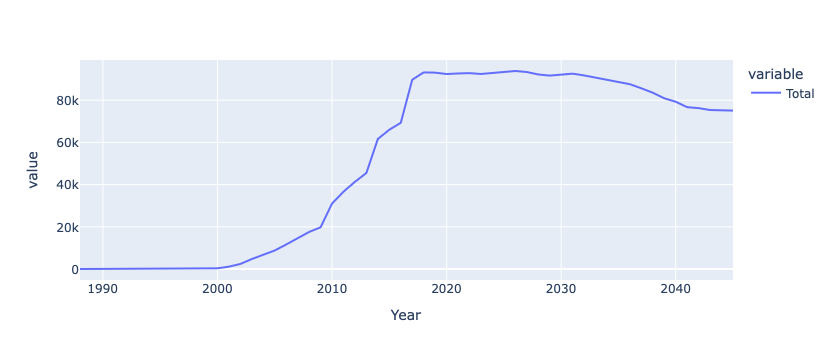

In [31]:
px.line(data_frame=ART_numbers_combined_wide_df, x='Year', y=['Total'])

### Of those on ART, % VL<1000 age 15-49

In [32]:
# Initialize an empty list to store individual dataframes
dfs = []

for seed_number, datalist in loaded_data.items():
    for timepoint in evaluation_timepoints:
        # agegroup = [15, 50]
        result_df = VL_suppression_calculator(datalist=datalist, agegroup=agegroup,timepoint=timepoint, vl_cutoff=1000)
        result_df['timepoint'] = timepoint - 0.5
        result_df['model'] = seed_number

        # Append the resulting dataframe to the list
        dfs.append(result_df)

# Concatenate all dataframes in the list into a single dataframe
VL_combined_df = pd.concat(dfs, ignore_index=True)
VL_combined_df = VL_combined_df.dropna(subset=['Gender'])
# Replace timepoint with years, gender with actual gender string
VL_combined_df['Year'] = VL_combined_df['timepoint'].map(timepoint_to_year)
VL_combined_df['Gender'] = VL_combined_df['Gender'].map(gender)

In [33]:
VL_df = VL_combined_df.groupby(['Gender','Year']).agg(
            vl_suppr_frac=('vl_suppr_frac', 'mean')  # Average pop for each gender
        ).reset_index()

VL_df['vl_suppr_frac'] = VL_df['vl_suppr_frac']

In [34]:
VL_wide_df = VL_df.pivot(index='Year', columns='Gender', values='vl_suppr_frac').reset_index()
VL_wide_df.columns.name = None  # Remove the name of the columns index

with pd.ExcelWriter(excel_file, engine='xlsxwriter') as writer:
    # Write each dataframe to a different worksheet
    population_wide_df.to_excel(writer, sheet_name='Population Size', index=False)
    prevalence_wide_df.to_excel(writer, sheet_name='HIV Prevalence', index=False)
    incidence_wide_df.to_excel(writer, sheet_name='HIV Incidence per 1000', index=False)
    ART_wide_df.to_excel(writer, sheet_name='ART Coverage', index=False)
    new_infections_wide_df.to_excel(writer, sheet_name='New HIV infections', index=False)
    ART_numbers_combined_wide_df.to_excel(writer, sheet_name='On Treatemnt All Ages', index=False)
    VL_wide_df.to_excel(writer, sheet_name='Virally Supressed', index=False)

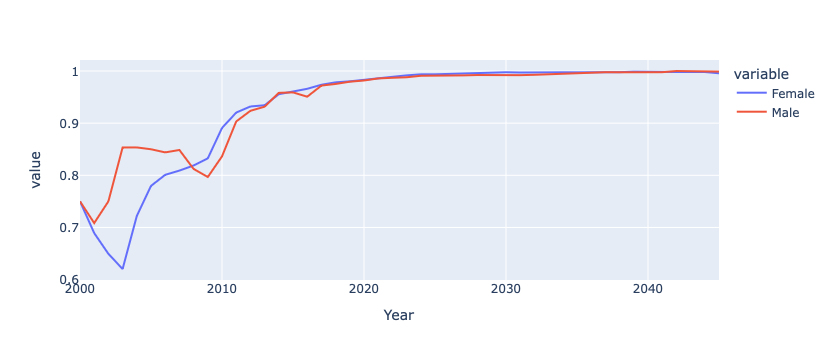

In [35]:
px.line(data_frame=VL_wide_df, x='Year', y=['Female','Male'])

### % of 15+ men who have had VMMC

In [36]:
# Initialize an empty list to store individual dataframes
dfs = []

for seed_number, datalist in loaded_data.items():
    for timepoint in evaluation_timepoints:
        # agegroup = [15, 50]
        result_df = vmmc_calculator(datalist=datalist, agegroup=[15,300],timepoint=timepoint)
        result_df['timepoint'] = timepoint - 0.5
        result_df['model'] = seed_number

        # Append the resulting dataframe to the list
        dfs.append(result_df)

# Concatenate all dataframes in the list into a single dataframe
VMMC_combined_df = pd.concat(dfs, ignore_index=True)

# Replace timepoint with years, gender with actual gender string
VMMC_combined_df['Year'] = VMMC_combined_df['timepoint'].map(timepoint_to_year)

In [37]:
VMMC_df = VMMC_combined_df.groupby(['Gender','Year']).agg(
            vmmcprevalence=('vmmcprevalence', 'mean')  # Average pop for each gender
        ).reset_index()

VMMC_df['vmmcprevalence'] = round(VMMC_df['vmmcprevalence'],4)

In [38]:
VMMC_wide_df = VMMC_df.pivot(index='Year', columns='Gender', values='vmmcprevalence').reset_index()
VMMC_wide_df.columns.name = None  # Remove the name of the columns index

with pd.ExcelWriter(excel_file, engine='xlsxwriter') as writer:
    # Write each dataframe to a different worksheet
    population_wide_df.to_excel(writer, sheet_name='Population Size', index=False)
    prevalence_wide_df.to_excel(writer, sheet_name='HIV Prevalence', index=False)
    incidence_wide_df.to_excel(writer, sheet_name='HIV Incidence per 1000', index=False)
    ART_wide_df.to_excel(writer, sheet_name='ART Coverage', index=False)
    new_infections_wide_df.to_excel(writer, sheet_name='New HIV infections', index=False)
    ART_numbers_combined_wide_df.to_excel(writer, sheet_name='On Treatemnt All Ages', index=False)
    VL_wide_df.to_excel(writer, sheet_name='Virally Supressed', index=False)
    VMMC_wide_df.to_excel(writer, sheet_name='VMMC', index=False)

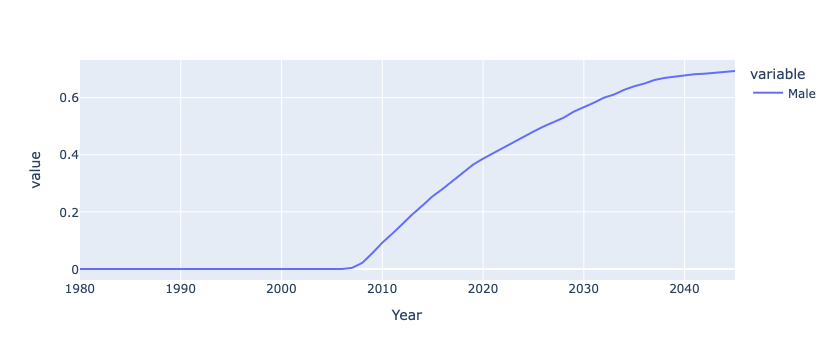

In [39]:
px.line(data_frame=VMMC_wide_df, x='Year', y=['Male'])

### Number of people living with HIV, ages 15+

In [40]:
# Prevalence calculator shows everyone infected and not necessarily diagnosed
# Initialize an empty list to store individual dataframes
dfs = []

for seed_number, datalist in loaded_data.items():
    for timepoint in evaluation_timepoints:
        result_df = prevalence_calculator(datalist=datalist, agegroup=[15, 200],timepoint=timepoint)
        result_df['timepoint'] = timepoint - 0.5
        result_df['model'] = seed_number

        # Append the resulting dataframe to the list
        dfs.append(result_df)

# Concatenate all dataframes in the list into a single dataframe
prev_all_ages_combined_df = pd.concat(dfs, ignore_index=True)

# Replace timepoint with years, gender with actual gender string
prev_all_ages_combined_df['Year'] = prev_all_ages_combined_df['timepoint'].map(timepoint_to_year)
prev_all_ages_combined_df['Gender'] = prev_all_ages_combined_df['Gender'].map(gender)

In [41]:
number_plwh_df = prev_all_ages_combined_df.groupby(['Gender','Year']).agg(
            number_plwh=('sum_cases', 'mean')  # Average number for each gender
        ).reset_index()

number_plwh_df['number_plwh'] = number_plwh_df['number_plwh'] 
number_plwh_df['Actual_number_plwh'] = round(number_plwh_df['number_plwh']*scaling_factor)

In [42]:
number_plwh_wide_df = number_plwh_df.pivot(index='Year', columns='Gender', values='Actual_number_plwh').reset_index()
number_plwh_wide_df.columns.name = None  # Remove the name of the columns index

In [43]:
with pd.ExcelWriter(excel_file, engine='xlsxwriter') as writer:
    # Write each dataframe to a different worksheet
    population_wide_df.to_excel(writer, sheet_name='Population Size', index=False)
    prevalence_wide_df.to_excel(writer, sheet_name='HIV Prevalence', index=False)
    incidence_wide_df.to_excel(writer, sheet_name='HIV Incidence per 1000', index=False)
    ART_wide_df.to_excel(writer, sheet_name='ART Coverage', index=False)
    new_infections_wide_df.to_excel(writer, sheet_name='New HIV infections', index=False)
    ART_numbers_combined_wide_df.to_excel(writer, sheet_name='On Treatemnt All Ages', index=False)
    VL_wide_df.to_excel(writer, sheet_name='Virally Supressed', index=False)
    VMMC_wide_df.to_excel(writer, sheet_name='VMMC', index=False)
    number_plwh_wide_df.to_excel(writer, sheet_name='Number of PLHIV', index=False)

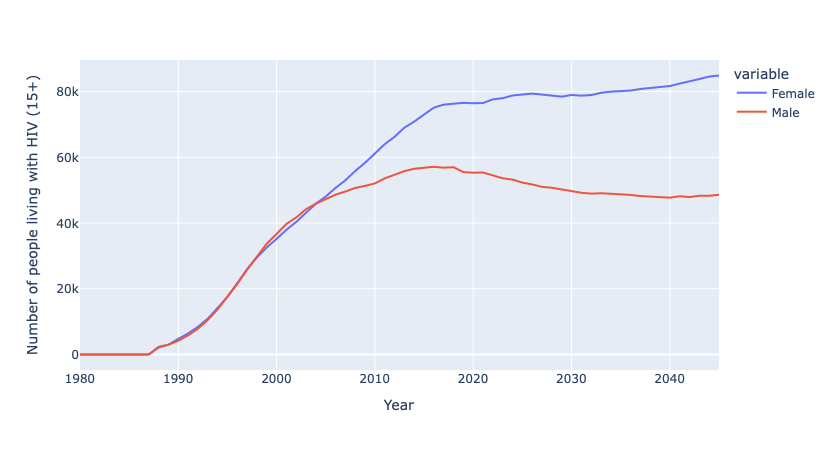

In [44]:
fig = px.line(data_frame=number_plwh_wide_df, x='Year', y=['Female','Male'],width=920, height=450)
fig.update_layout(
    xaxis_title="Year", yaxis_title="Number of people living with HIV (15+)"
)
fig.show()

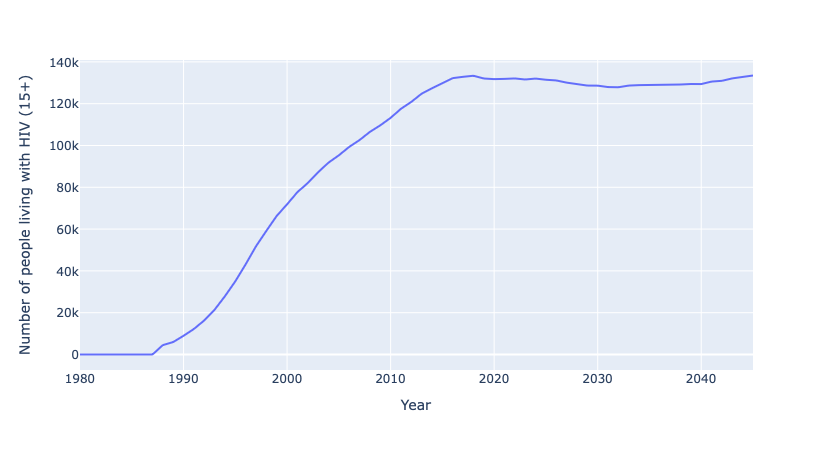

In [45]:
fig = px.line(data_frame=number_plwh_wide_df, x='Year', y='Total',width=920, height=450)
fig.update_layout(
    xaxis_title="Year", yaxis_title="Number of people living with HIV (15+)"
)
fig.show()

### Proportion diagnosed age 15-49

In [46]:
# Initialize an empty list to store individual dataframes
dfs = []

for seed_number, datalist in loaded_data.items():
    for timepoint in evaluation_timepoints:
        # agegroup = [15, 50]
        result_df = proportion_diagnosed_calculator(datalist=datalist, agegroup=agegroup,timepoint=timepoint)
        result_df['timepoint'] = timepoint - 0.5
        result_df['model'] = seed_number

        # Append the resulting dataframe to the list
        dfs.append(result_df)

# Concatenate all dataframes in the list into a single dataframe
prev_diag_combined_df = pd.concat(dfs, ignore_index=True)

# Replace timepoint with years, gender with actual gender string
prev_diag_combined_df['Year'] = prev_diag_combined_df['timepoint'].map(timepoint_to_year)
prev_diag_combined_df['Gender'] = prev_diag_combined_df['Gender'].map(gender)

In [47]:
diagnosed_df = prev_diag_combined_df.groupby(['Gender','Year']).agg(
            propdiagnosed=('propdiagnosed', 'mean')  # Average pop for each gender
        ).reset_index()

In [48]:
diagnosed_wide_df = diagnosed_df.pivot(index='Year', columns='Gender', values='propdiagnosed').reset_index()
diagnosed_wide_df.columns.name = None  # Remove the name of the columns index

with pd.ExcelWriter(excel_file, engine='xlsxwriter') as writer:
    # Write each dataframe to a different worksheet
    population_wide_df.to_excel(writer, sheet_name='Population Size', index=False)
    prevalence_wide_df.to_excel(writer, sheet_name='HIV Prevalence', index=False)
    incidence_wide_df.to_excel(writer, sheet_name='HIV Incidence per 1000', index=False)
    ART_wide_df.to_excel(writer, sheet_name='ART Coverage', index=False)
    new_infections_wide_df.to_excel(writer, sheet_name='New HIV infections', index=False)
    ART_numbers_combined_wide_df.to_excel(writer, sheet_name='On Treatemnt All Ages', index=False)
    VL_wide_df.to_excel(writer, sheet_name='Virally Supressed', index=False)
    VMMC_wide_df.to_excel(writer, sheet_name='VMMC', index=False)
    number_plwh_wide_df.to_excel(writer, sheet_name='Number of PLHIV', index=False)
    diagnosed_wide_df.to_excel(writer, sheet_name='Proportion Diagnosed', index=False)

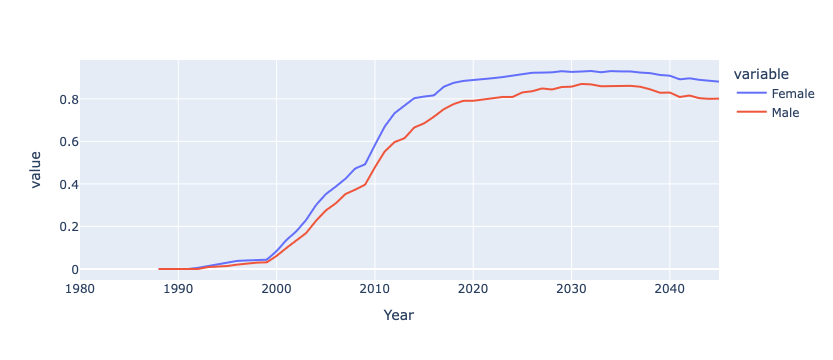

In [49]:
px.line(data_frame=diagnosed_wide_df, x='Year', y=['Female','Male'])

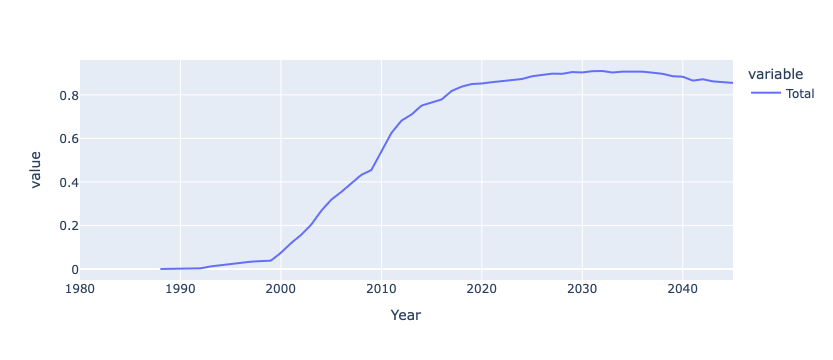

In [50]:
px.line(data_frame=diagnosed_wide_df, x='Year', y=['Total'])

### HIV-related deaths 15+

In [51]:
# Initialize an empty list to store individual dataframes
dfs = []

for seed_number, datalist in loaded_data.items():
    for timepoint in evaluation_timepoints_inc:
        timewindow = [timepoint, timepoint+1]
        agegroup = [0, 200]
        result_df = AIDS_deaths_calculator(datalist=datalist, agegroup=agegroup,timewindow=timewindow)
        result_df['timepoint'] = timepoint+1 
        result_df['model'] = seed_number

        # Append the resulting dataframe to the list
        dfs.append(result_df)

# Concatenate all dataframes in the list into a single dataframe
AIDS_deaths_combined_df = pd.concat(dfs, ignore_index=True)
AIDS_deaths_combined_df = AIDS_deaths_combined_df.dropna(subset=['Gender'])
# Replace timepoint with years, gender with actual gender string
AIDS_deaths_combined_df['Year'] = AIDS_deaths_combined_df['timepoint'].map(timepoint_to_year)
AIDS_deaths_combined_df['Gender'] = AIDS_deaths_combined_df['Gender'].map(gender)

In [52]:
AIDS_deaths_df = AIDS_deaths_combined_df.groupby(['Gender','Year']).agg(
            sum_AIDSDeath=('sum_AIDSDeath', 'mean')  # Average pop for each gender
        ).reset_index()

AIDS_deaths_df['sum_AIDSDeath_actual'] = round(AIDS_deaths_df['sum_AIDSDeath']*scaling_factor)

In [53]:
AIDS_deaths_wide_df = AIDS_deaths_df.pivot(index='Year', columns='Gender', values='sum_AIDSDeath_actual').reset_index()
AIDS_deaths_wide_df.columns.name = None  # Remove the name of the columns index

In [54]:
with pd.ExcelWriter(excel_file, engine='xlsxwriter') as writer:
    # Write each dataframe to a different worksheet
    population_wide_df.to_excel(writer, sheet_name='Population Size', index=False)
    prevalence_wide_df.to_excel(writer, sheet_name='HIV Prevalence', index=False)
    incidence_wide_df.to_excel(writer, sheet_name='HIV Incidence per 1000', index=False)
    ART_wide_df.to_excel(writer, sheet_name='ART Coverage', index=False)
    new_infections_wide_df.to_excel(writer, sheet_name='New HIV infections', index=False)
    ART_numbers_combined_wide_df.to_excel(writer, sheet_name='On Treatemnt All Ages', index=False)
    VL_wide_df.to_excel(writer, sheet_name='Virally Supressed', index=False)
    VMMC_wide_df.to_excel(writer, sheet_name='VMMC', index=False)
    number_plwh_wide_df.to_excel(writer, sheet_name='Number of PLHIV', index=False)
    diagnosed_wide_df.to_excel(writer, sheet_name='Proportion Diagnosed', index=False)
    AIDS_deaths_wide_df.to_excel(writer, sheet_name='HIV AIDS Deaths', index=False)

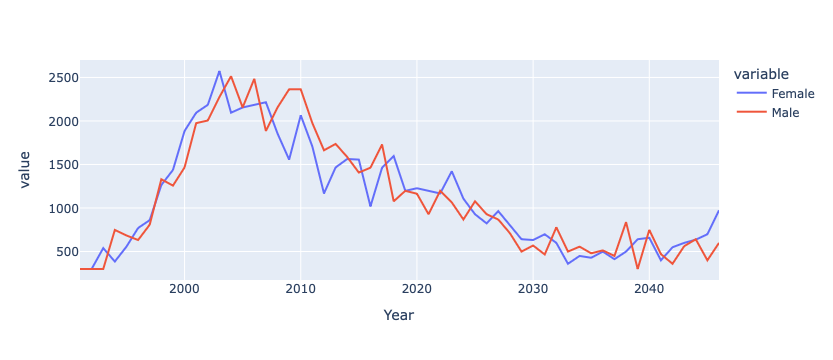

In [55]:
px.line(data_frame=AIDS_deaths_wide_df, x='Year', y=['Female','Male'])

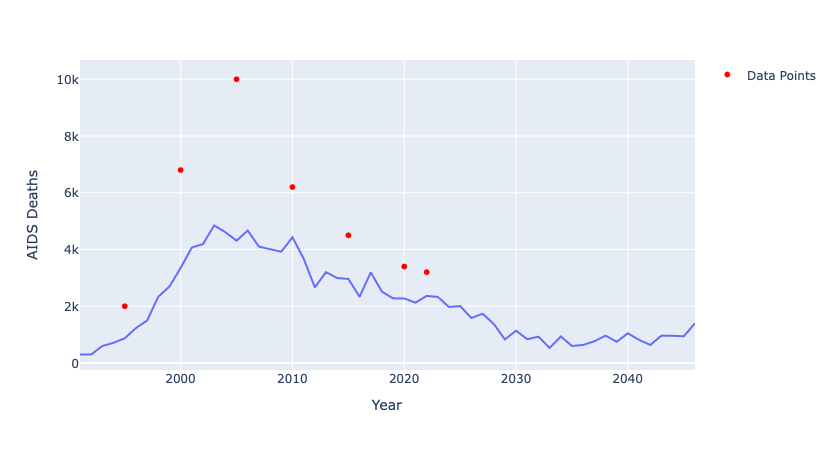

In [56]:
fig = px.line(data_frame=AIDS_deaths_wide_df, x='Year', y='Total',width=890, height=450)
fig.update_layout(
    xaxis_title="Year", yaxis_title="AIDS Deaths"
)

# Data points to add
points = [
    {'Year': 1995, 'Total': 2000},
    {'Year': 2000, 'Total': 6800},
    {'Year': 2005, 'Total': 10000},
    {'Year': 2010, 'Total': 6200},
    {'Year': 2015, 'Total': 4500},
    {'Year': 2020, 'Total': 3400},
    {'Year': 2022, 'Total': 3200},
    # Add more points as needed
]

# Add points for Female
fig.add_trace(
    go.Scatter(
        x=[point['Year'] for point in points],
        y=[point['Total'] for point in points],
        mode='markers',
        name='Data Points',
        marker=dict(color='red', size=6)
    )
)

# Show the plot
fig.show()

### HIV incidence as new infections per 1000 uninfected population  (15-24)

In [57]:
# Initialize an empty list to store individual dataframes
dfs = []

for seed_number, datalist in loaded_data.items():
    for timepoint in evaluation_timepoints_inc:
        timewindow = [timepoint, timepoint+1]
        result_df = incidence_calculator(datalist=datalist, agegroup=[15,25],timewindow=timewindow)
        result_df['timepoint'] = timepoint+1
        result_df['model'] = seed_number

        # Append the resulting dataframe to the list
        dfs.append(result_df)

# Concatenate all dataframes in the list into a single dataframe
inc_combined_df_24 = pd.concat(dfs, ignore_index=True)

# Replace timepoint with years, gender with actual gender string
inc_combined_df_24['Year'] = inc_combined_df_24['timepoint'].map(timepoint_to_year)
inc_combined_df_24['Gender'] = inc_combined_df_24['Gender'].map(gender)

In [58]:
incidence_df_24 = inc_combined_df_24.groupby(['Gender','Year']).agg(
            incidence=('incidence', 'mean')  # Average pop for each gender
        ).reset_index()

incidence_df_24['incidence'] = round(incidence_df_24['incidence'] * 1000, 3)

In [59]:
incidence_24_wide_df = incidence_df_24.pivot(index='Year', columns='Gender', values='incidence').reset_index()
incidence_24_wide_df.columns.name = None  # Remove the name of the columns index

with pd.ExcelWriter(excel_file, engine='xlsxwriter') as writer:
    # Write each dataframe to a different worksheet
    population_wide_df.to_excel(writer, sheet_name='Population Size', index=False)
    prevalence_wide_df.to_excel(writer, sheet_name='HIV Prevalence', index=False)
    incidence_wide_df.to_excel(writer, sheet_name='HIV Incidence per 1000', index=False)
    ART_wide_df.to_excel(writer, sheet_name='ART Coverage', index=False)
    new_infections_wide_df.to_excel(writer, sheet_name='New HIV infections', index=False)
    ART_numbers_combined_wide_df.to_excel(writer, sheet_name='On Treatemnt All Ages', index=False)
    VL_wide_df.to_excel(writer, sheet_name='Virally Supressed', index=False)
    VMMC_wide_df.to_excel(writer, sheet_name='VMMC', index=False)
    number_plwh_wide_df.to_excel(writer, sheet_name='Number of PLHIV', index=False)
    diagnosed_wide_df.to_excel(writer, sheet_name='Proportion Diagnosed', index=False)
    AIDS_deaths_wide_df.to_excel(writer, sheet_name='HIV AIDS Deaths', index=False)
    incidence_24_wide_df.to_excel(writer, sheet_name='HIV Incidence per 1000 15-24', index=False)

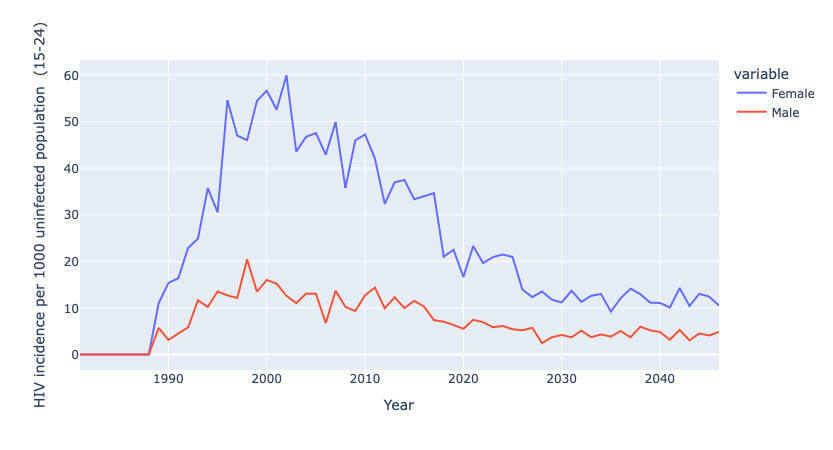

In [60]:
fig = px.line(data_frame=incidence_24_wide_df, x='Year', y=['Female','Male'],width=920, height=450)
fig.update_layout(
    xaxis_title="Year", yaxis_title="HIV incidence per 1000 uninfected population  (15-24)"
)

# Show the plot
fig.show()

### New HIV infections age 15-24 pop

In [61]:
new_infections_df_24 = inc_combined_df_24.groupby(['Gender','Year']).agg(
            sum_incident_cases=('sum_incident_cases', 'mean')  # Average pop for each gender
        ).reset_index()

new_infections_df_24['sum_incident_cases_actual'] = round(new_infections_df_24['sum_incident_cases']*scaling_factor)

In [62]:
new_infections_24_wide_df = new_infections_df_24.pivot(index='Year', columns='Gender', values='sum_incident_cases_actual').reset_index()
new_infections_24_wide_df.columns.name = None  # Remove the name of the columns index

with pd.ExcelWriter(excel_file, engine='xlsxwriter') as writer:
    # Write each dataframe to a different worksheet
    population_wide_df.to_excel(writer, sheet_name='Population Size', index=False)
    prevalence_wide_df.to_excel(writer, sheet_name='HIV Prevalence', index=False)
    incidence_wide_df.to_excel(writer, sheet_name='HIV Incidence per 1000', index=False)
    ART_wide_df.to_excel(writer, sheet_name='ART Coverage', index=False)
    new_infections_wide_df.to_excel(writer, sheet_name='New HIV infections', index=False)
    ART_numbers_combined_wide_df.to_excel(writer, sheet_name='On Treatemnt All Ages', index=False)
    VL_wide_df.to_excel(writer, sheet_name='Virally Supressed', index=False)
    VMMC_wide_df.to_excel(writer, sheet_name='VMMC', index=False)
    number_plwh_wide_df.to_excel(writer, sheet_name='Number of PLHIV', index=False)
    diagnosed_wide_df.to_excel(writer, sheet_name='Proportion Diagnosed', index=False)
    AIDS_deaths_wide_df.to_excel(writer, sheet_name='HIV AIDS Deaths', index=False)
    incidence_24_wide_df.to_excel(writer, sheet_name='HIV Incidence per 1000 15-24', index=False)
    new_infections_24_wide_df.to_excel(writer, sheet_name='New HIV infections 15-24', index=False)

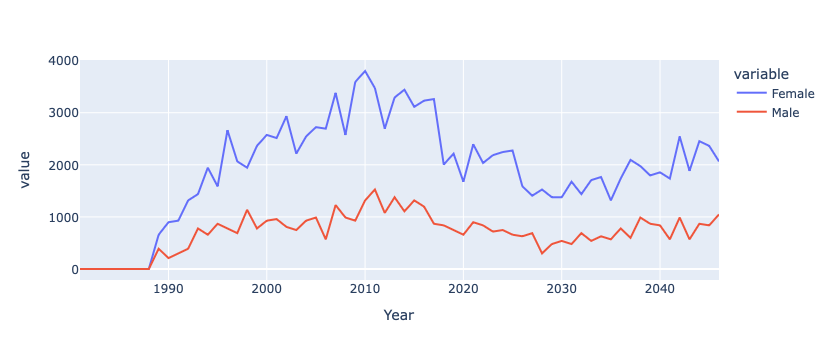

In [63]:
px.line(data_frame=new_infections_24_wide_df, x='Year', y=['Female','Male'])